# Optimization

In this practice session, we explicitely control for the optimisation algorithms, the activation functions, the parameter initilisation scheme and different forms of regularisation.


In [1]:
# Modules
import numpy as np
import pandas as pd

from matplotlib import pyplot
from tensorflow.keras import callbacks, initializers, layers, losses, models, optimizers
from sklearn import datasets, metrics, model_selection, preprocessing

1. Load the `cancer` dataset and produce some descriptive statistics for the input and the target.

In [2]:
# Loads dataset
X, y = datasets.load_breast_cancer(return_X_y=True, as_frame=True)

# Descriptive statistcs
X.describe()
y.value_counts()

1    357
0    212
Name: target, dtype: int64

2. Split the data into a training (75%) and a test sample (25%) and standardise the input variables appropriately (see `sklearn.model_selection` and `sklearn.preprocessing`).

In [3]:
# Train - test split
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y.values.astype(float), test_size=0.25, random_state=0)

# Standardisation
scaler  = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

3. Using the `tensorflow.keras` functional API, build a feed-forward network structure with an input layer, two hidden layers containing 32 units each with `relu` activation and the `HeNormal` initialisation, as well as an output layer with the appropriate activation function. Use the `summary` method of the model to visualise the structure.

In [4]:
# Models structure
def build_model(input_shape:int):
  initializer = initializers.HeNormal(seed=0)
  inputs  = layers.Input(shape=(input_shape,), name='input_layer')
  hidden  = layers.Dense(units=32, activation='relu',    kernel_initializer=initializer, name='hidden_layer1')(inputs)
  hidden  = layers.Dense(units=32, activation='relu',    kernel_initializer=initializer, name='hidden_layer2')(hidden)
  outputs = layers.Dense(units=1,  activation='sigmoid', kernel_initializer=initializer, name='output_layer')(hidden)
  model   = models.Model(inputs=inputs, outputs=outputs, name='simple_model')
  return model

# Builds model
model = build_model(input_shape=30)
model.summary()

Model: "simple_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 30)]              0         
                                                                 
 hidden_layer1 (Dense)       (None, 32)                992       
                                                                 
 hidden_layer2 (Dense)       (None, 32)                1056      
                                                                 
 output_layer (Dense)        (None, 1)                 33        
                                                                 
Total params: 2,081
Trainable params: 2,081
Non-trainable params: 0
_________________________________________________________________


/Users/clementgorin/miniforge3/envs/machinelearning/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


4. Compile the model with the appropriate loss function and an optimiser of you choice. Use the `metrics` parameter to monitor the evolution of the `Recall` and `Precision` scores for each training epoch during training. Train the model using 100 epochs.

In [5]:
# Compiles model
model.compile(
    loss=losses.BinaryCrossentropy(),
    optimizer=optimizers.Adam(learning_rate=0.001), 
    metrics=['BinaryAccuracy', 'Recall', 'Precision'])

# Estimates model
train_params = dict(epochs=100, verbose=1)
training     = model.fit(X_train, y_train, **train_params)

Epoch 1/100


2023-03-15 10:42:04.494391: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


14/14 [==============================] - 0s 951us/step - loss: 1.1464 - binary_accuracy: 0.3638 - recall: 0.0150 - precision: 0.3333  
Epoch 2/100
14/14 [==============================] - 0s 790us/step - loss: 0.6800 - binary_accuracy: 0.5845 - recall: 0.3633 - precision: 0.9327
Epoch 3/100
14/14 [==============================] - 0s 741us/step - loss: 0.4607 - binary_accuracy: 0.8521 - recall: 0.7978 - precision: 0.9595
Epoch 4/100
14/14 [==============================] - 0s 833us/step - loss: 0.3370 - binary_accuracy: 0.9131 - recall: 0.9064 - precision: 0.9528
Epoch 5/100
14/14 [==============================] - 0s 720us/step - loss: 0.2648 - binary_accuracy: 0.9390 - recall: 0.9551 - precision: 0.9480
Epoch 6/100
14/14 [==============================] - 0s 711us/step - loss: 0.2134 - binary_accuracy: 0.9460 - recall: 0.9700 - precision: 0.9453
Epoch 7/100
14/14 [==============================] - 0s 730us/step - loss: 0.1804 - binary_accuracy: 0.9554 - recall: 0.9850 - precision: 0.

5. Display the evolution of the loss on the training sample during optimisation. This can be done by assigning the `model.fit` object e.g. `training = model.fit(...)` and using the history attribute e.g. `training.history`.

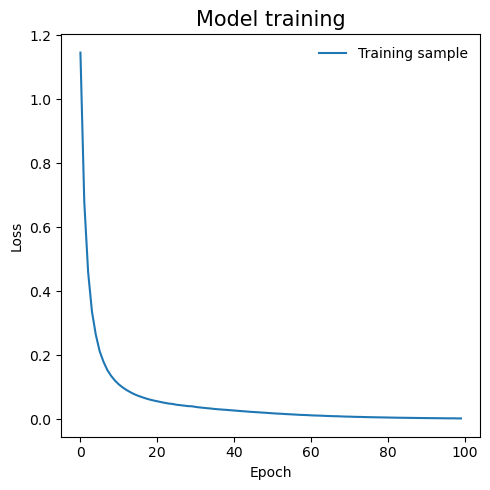

In [6]:
def display_history(history:dict, stat:str='loss', validation:bool=False) -> None:
    '''Displays training history for a statistic'''
    fig, ax = pyplot.subplots(1, figsize=(5, 5))
    ax.plot(history[stat], label='Training sample')
    if validation:
        ax.plot(history[f'val_{stat}'], label='Validation sample')
    ax.set_title(f'Model training', fontsize=15)
    ax.set_ylabel(stat.title())
    ax.set_xlabel('Epoch')
    ax.legend(frameon=False)
    pyplot.tight_layout()
    pyplot.show()

# Plot history
display_history(training.history)

6. Compute the receiver operating characteristic (ROC) curve (see `metrics.roc_curve`) on the test sample to choose a probability threshold using Youden's J statistic. Using this threshold, compute the confusion matrix on the test sample.

5/5 [==============================] - 0s 583us/step


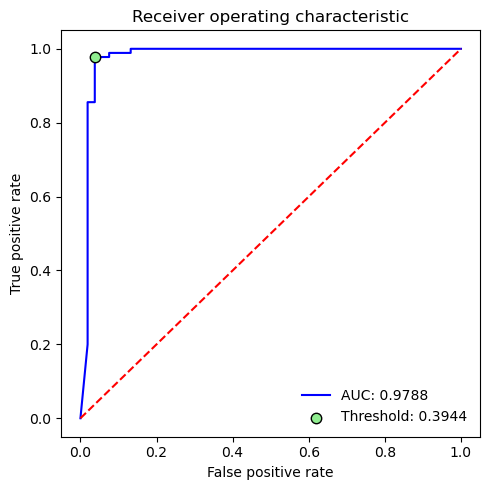

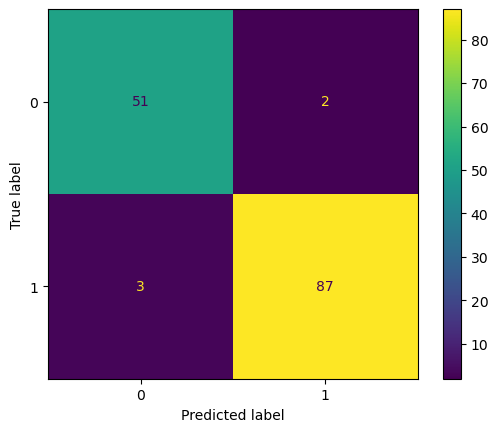

In [7]:
def display_roc(fp_rates:np.ndarray, tp_rates:np.ndarray, thresholds:np.ndarray, best_index:int=None) -> None:
    '''Displays ROC curve and AUC'''
    auc     = metrics.auc(fp_rates, tp_rates)
    fig, ax = pyplot.subplots(1, figsize=(5, 5))
    ax.plot(fp_rates, tp_rates, color='blue', label=f'AUC: {auc:0.4f}')
    ax.plot([0, 1], [0, 1], color='red', linestyle='dashed')
    if best_index is not None:
        ax.scatter(fp_rates[best_index], tp_rates[best_index], marker='o', c='lightgreen', s=7.5**2, edgecolor='black', zorder=2, label=f'Threshold: {thresholds[best_index]:0.4f}')
    ax.set_title('Receiver operating characteristic')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.legend(loc='lower right', frameon=False)
    pyplot.tight_layout()
    pyplot.show()

# ROC curve
yh_test = np.squeeze(model.predict(X_test))
fp_rates, tp_rates, thresholds = metrics.roc_curve(y_test, yh_test)
youden = np.argmax(tp_rates - fp_rates)
display_roc(fp_rates, tp_rates, thresholds, youden)

# Confusion matrix
confmat = metrics.confusion_matrix(y_test, yh_test > thresholds[youden])
confmat = metrics.ConfusionMatrixDisplay(confusion_matrix=confmat)
confmat.plot()

7. Train the model with a validation sample using 25% of the training observations (see the `validation_split` argument). Implement an early stopping callback using a patience of 5 (see `keras.callbacks`). Display the evolution of the training and validation loss during training. Which epoch gave the model with the best generalisation performance?

Epoch 1/100


/Users/clementgorin/miniforge3/envs/machinelearning/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


10/10 [==============================] - 1s 15ms/step - loss: 0.8327 - binary_accuracy: 0.6552 - recall: 0.9951 - precision: 0.6495 - val_loss: 0.7359 - val_binary_accuracy: 0.6636 - val_recall: 1.0000 - val_precision: 0.6400
Epoch 2/100
10/10 [==============================] - 0s 3ms/step - loss: 0.5427 - binary_accuracy: 0.7304 - recall: 0.9852 - precision: 0.7067 - val_loss: 0.4471 - val_binary_accuracy: 0.8224 - val_recall: 0.9844 - val_precision: 0.7778
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 0.3631 - binary_accuracy: 0.8621 - recall: 0.9852 - precision: 0.8299 - val_loss: 0.3191 - val_binary_accuracy: 0.8972 - val_recall: 0.9844 - val_precision: 0.8630
Epoch 4/100
10/10 [==============================] - 0s 3ms/step - loss: 0.2770 - binary_accuracy: 0.8997 - recall: 0.9852 - precision: 0.8734 - val_loss: 0.2515 - val_binary_accuracy: 0.9159 - val_recall: 0.9531 - val_precision: 0.9104
Epoch 5/100
10/10 [==============================] - 0s 3ms/ste

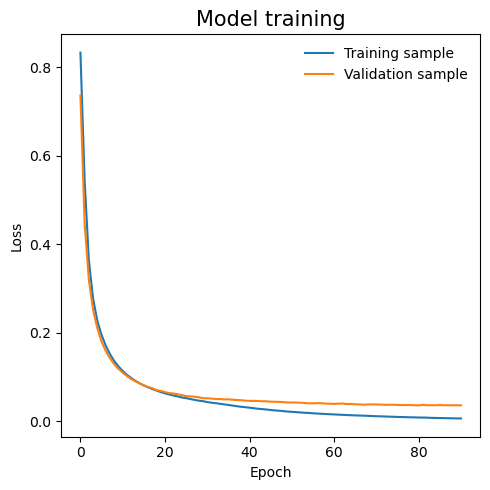

Best epoch: 80
5/5 [==============================] - 0s 1ms/step - loss: 0.1609 - binary_accuracy: 0.9720 - recall: 0.9778 - precision: 0.9778


In [8]:
# Resets model
model = build_model(input_shape=30)
model.compile(
    loss=losses.BinaryCrossentropy(),
    optimizer=optimizers.Adam(learning_rate=0.001), 
    metrics=['BinaryAccuracy', 'Recall', 'Precision'])

# Callbacks
train_callbacks = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
train_params.update(callbacks=train_callbacks)
del train_callbacks

# Training with validation
training = model.fit(
    X_train, y_train, 
    validation_split=0.25,
    **train_params)

# Displays history
display_history(training.history, validation=True)
print(f"Best epoch: {np.argmin(training.history['val_loss'])}")

# Generalisation performance
earlystop_stats = model.evaluate(X_test, y_test)

8. Modify the model structure in (3) using dropout regularisation for each hidden layer with a rate of 10%. Re-estimate the model with early stopping. Does the model generalise better than the one in (7)?

In [9]:
# Model structure
def build_model(input_shape:int):
  initializer = initializers.HeNormal(seed=0)
  inputs  = layers.Input(shape=(input_shape,), name='input_layer')
  hidden  = layers.Dense(units=32, activation='relu', kernel_initializer=initializer, name='hidden_layer1')(inputs)
  hidden  = layers.Dropout(rate=0.1, name='droupout_layer1')(hidden)
  hidden  = layers.Dense(units=32, activation='relu', kernel_initializer=initializer, name='hidden_layer2')(hidden)
  hidden  = layers.Dropout(rate=0.1, name='droupout_layer2')(hidden)
  outputs = layers.Dense(units=1,  activation='sigmoid', name='output_layer')(hidden)
  model   = models.Model(inputs=inputs, outputs=outputs, name='dropout_model')
  return model

# Re-run code in question (7)...

# Generalisation performance
dropout_stats = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 846us/step - loss: 0.1609 - binary_accuracy: 0.9720 - recall: 0.9778 - precision: 0.9778


9. Modify the model structure in (3) using a batch-normalisation layer before the activation of each hidden layer. Re-estimate the model with early stopping. Does the model generalise better than the one in (7)?

In [10]:
# Model structure
def build_model(input_shape:int):
  initializer = initializers.HeNormal()
  inputs  = layers.Input(shape=(input_shape,), name='input_layer')
  hidden  = layers.Dense(units=32, activation='linear', kernel_initializer=initializer, name='hidden_layer1')(inputs)
  hidden  = layers.BatchNormalization(name='batchnorm_layer1')(hidden)
  hidden  = layers.Activation('relu', name='activation_layer1')(hidden) 
  hidden  = layers.Dense(units=32, activation='linear', kernel_initializer=initializer, name='hidden_layer2')(hidden)
  hidden  = layers.BatchNormalization(name='batchnorm_layer2')(hidden)
  hidden  = layers.Activation('relu', name='activation_layer2')(hidden) 
  outputs = layers.Dense(units=1,  activation='sigmoid', name='output_layer')(hidden)
  model   = models.Model(inputs=inputs, outputs=outputs, name='batchnorm_model')
  return model

# Re-run code in question (7)...

# Generalisation performance
batchnorm_stats = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 909us/step - loss: 0.1609 - binary_accuracy: 0.9720 - recall: 0.9778 - precision: 0.9778
